### MIE1624 Assignment 1 Salary Classification
 - Zijing Yu


### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, log_loss

### Read in data

In [2]:
df = pd.read_csv('Kaggle_Salary.csv')
df.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (73,77,114,146,153,171,175,212,224,228,231) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,...,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets
0,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,3,"30,000-39,999"
1,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
2,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,...,NaN,NaN,NaN,Azure SQL Database,NaN,NaN,NaN,-1,14,">250,000"
3,392,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
4,470,50-54,Male,-1,France,Master’s degree,Data Scientist,-1,0-49 employees,3-4,...,NaN,AWS Relational Database Service,NaN,NaN,NaN,NaN,NaN,-1,6,"60,000-69,999"


### General information of the data
 - set m to be the number of samples
 - set n to be the number of columns

In [3]:
m,n=df.shape
print (m,n)

12497 248


Show target.

In [4]:
df['Q10_Encoded'].unique()

array([ 3,  0, 14,  6,  1,  8,  7,  9, 11,  4,  2, 10, 12, 13,  5])

Show null values in each column as a heatmap. Red parts indicate null values.

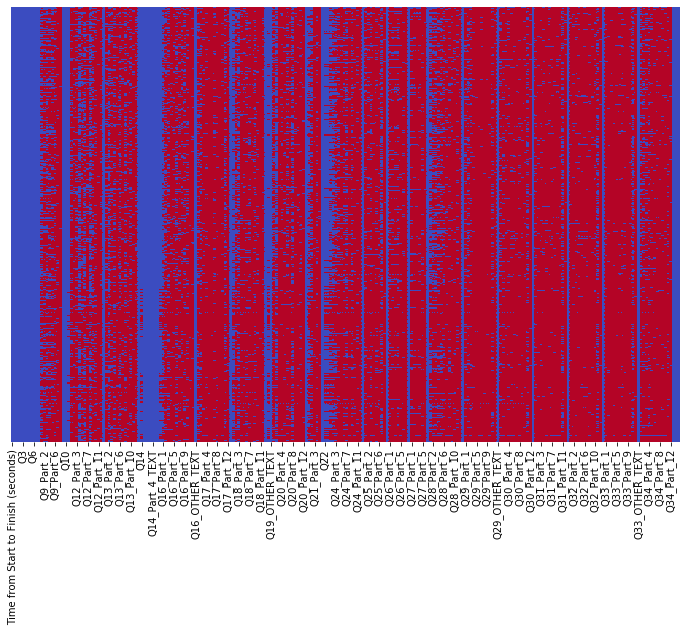

In [5]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)

For a single response question, respondents may miss the question and not provide answer. For a multiple response question, missing values are mainly due to that respondents did not select the option. We need to deal with the two types of questions in different ways.

### Data cleaning
Drop all 'Other_Text' columns. 'Other_Text' column is simply used to count how many times 'other' appears for a question, and it is not useful in classification model.

In [6]:
# drop columns of 'other_text'

key = 'OTHER_TEXT'
ot = df.columns[df.columns.str.contains(key)==True]
df1 = df.drop(ot, axis=1)

#### 1.Multiple response question
First, let's select the multiple response questions from all 34 questions.

In [7]:
# we know that there are total 34 questions
qlist = []
for i in range(34):
    key_str = 'Q'+str(i+1)+'_P'
    k = df.columns[df.columns.str.contains(key_str)==True]
    if len(k)>0:
        qlist.append(key_str.replace('_P',''))
qlist

['Q9',
 'Q12',
 'Q13',
 'Q14',
 'Q16',
 'Q17',
 'Q18',
 'Q20',
 'Q21',
 'Q24',
 'Q25',
 'Q26',
 'Q27',
 'Q28',
 'Q29',
 'Q30',
 'Q31',
 'Q32',
 'Q33',
 'Q34']

Show the entire set of multiple response questions.

In [8]:
mqlist = []
for q in qlist:
    k = df1.columns[df1.columns.str.contains(q)==True]
    mqlist.append(k)
mqlist

[Index(['Q9_Part_1', 'Q9_Part_2', 'Q9_Part_3', 'Q9_Part_4', 'Q9_Part_5',
        'Q9_Part_6', 'Q9_Part_7', 'Q9_Part_8'],
       dtype='object'),
 Index(['Q12_Part_1', 'Q12_Part_2', 'Q12_Part_3', 'Q12_Part_4', 'Q12_Part_5',
        'Q12_Part_6', 'Q12_Part_7', 'Q12_Part_8', 'Q12_Part_9', 'Q12_Part_10',
        'Q12_Part_11', 'Q12_Part_12'],
       dtype='object'),
 Index(['Q13_Part_1', 'Q13_Part_2', 'Q13_Part_3', 'Q13_Part_4', 'Q13_Part_5',
        'Q13_Part_6', 'Q13_Part_7', 'Q13_Part_8', 'Q13_Part_9', 'Q13_Part_10',
        'Q13_Part_11', 'Q13_Part_12'],
       dtype='object'),
 Index(['Q14', 'Q14_Part_1_TEXT', 'Q14_Part_2_TEXT', 'Q14_Part_3_TEXT',
        'Q14_Part_4_TEXT', 'Q14_Part_5_TEXT'],
       dtype='object'),
 Index(['Q16_Part_1', 'Q16_Part_2', 'Q16_Part_3', 'Q16_Part_4', 'Q16_Part_5',
        'Q16_Part_6', 'Q16_Part_7', 'Q16_Part_8', 'Q16_Part_9', 'Q16_Part_10',
        'Q16_Part_11', 'Q16_Part_12'],
       dtype='object'),
 Index(['Q17_Part_1', 'Q17_Part_2', 'Q17_Part_3', 'Q

Notice there is difference between 'Q14' and other multiple response questions. 
 - 'Q14' is actually a single response question. The parts of 'Q14' indicate which option of 'Q14' is selected. 
 - We eliminate 'Q14' from the multiple response question list.

In [9]:
qlist.remove('Q14')

Create a column to store the number of options a sample selected for each multiple response question.

In [10]:
# count options selected for each multiple response question
for i in range(len(qlist)):
    mu = df1.columns[df1.columns.str.contains(qlist[i])==True]   #select parts of a multiple response question
    notnanlist = df1[mu].notnull().sum(axis=1) 
    countname = qlist[i]+'_count'
    df1[countname] = notnanlist

A sample missed a multiple response question if the sample has NaN values for all parts of the multiple response question, which means 'count'=0 in this case. 

In [11]:
count_columns = df1[df1.columns[df1.columns.str.contains('count')==True]]
count_columns.eq(0).sum()

Q9_count     3462
Q12_count     494
Q13_count     605
Q16_count    1718
Q17_count    1816
Q18_count    1834
Q20_count    1920
Q21_count    1940
Q24_count    1990
Q25_count    2053
Q26_count    8477
Q27_count    9703
Q28_count    2123
Q29_count    5372
Q30_count    5397
Q31_count    5419
Q32_count    5447
Q33_count    5482
Q34_count    5503
dtype: int64

Remove questions that contain missing values exceeding 60% of total samples (=7498 in this dataset). For a feature that contains a large amount of missing values, it is less likely that the feature would provide useful information for classification model. Besides, it lacks enough information to help fill in the missing values. 
- 'Q26_count' and 'Q27_count' have 0 values more than 8000. We drop all parts of 'Q26' and 'Q27'. 

In [12]:
# drop columns that contain missing values exceeding 60% of total samples
drop = 0.6*m
for i in range(len(qlist)):
    if count_columns.eq(0).sum()[i]>drop:
        a = df1.columns[df1.columns.str.contains(qlist[i])]
        for j in range(len(a)):
            df1 = df1.drop(a[j], axis=1)


In [13]:
qlist.remove('Q26')
qlist.remove('Q27')

For the rest, fill in missing values of a sample with modes for the samples in the same 'Q10_Encoded'(salary) category.
- There are total 15 (0-14) categories of salary.
- This method makes more samples belonging to the same salary category share same values for features.

In [14]:
for mq in qlist:   #for a multiple response question 
    mqlist = df1.columns[df1.columns.str.contains(mq+'_Part')]   #select all parts of the multiple response question 
    non_nanlist = df1[df1[mq+'_count']!=0]    #exclude samples with missing values
    indexlist = df1.index[df1[mq+'_count']==0]    #select samples with missing values

    for part in mqlist:   #for a part of the multiple response question
        for i in range(15):    
            sam_i = non_nanlist[non_nanlist['Q10_Encoded']==i]   #select non-null samples with salary category i
            mo=sam_i[part].mode(dropna=False)[0]   #return mode of the part for salary category i
            if type(mo)==str:     #type(nan) returns float; otherwise type(mode) returns str
                                  #if the mode is 'nan', there is no need to fill in the missing value 'nan'
                for j in indexlist:
                    if df1.loc[j, 'Q10_Encoded']==i:    #check if the sample belongs to salary category i
                        df1.loc[j,part]=mo      #fill in the missing value with the mode


Update the 'count' columns and check if there is 'count'=0.

In [15]:
for i in range(len(qlist)):
    mu = df1.columns[df1.columns.str.contains(qlist[i])==True]   #select parts of a multiple response question
    notnanlist = df1[mu].notnull().sum(axis=1) 
    df1[qlist[i]+'_count'] = notnanlist

In [16]:
count_column = df1[df1.columns[df1.columns.str.contains('count')]]
count_column.eq(0).sum()

Q9_count     0
Q12_count    0
Q13_count    0
Q16_count    0
Q17_count    0
Q18_count    0
Q20_count    0
Q21_count    0
Q24_count    0
Q25_count    0
Q28_count    0
Q29_count    0
Q30_count    0
Q31_count    0
Q32_count    0
Q33_count    0
Q34_count    0
dtype: int64

Drop useless features: the parts that contain NaN values more than 60% of total samples.

In [17]:
for mq in qlist:   
  mqlist = df1.columns[df1.columns.str.contains(mq+'_Part')]   
  for part in mqlist: 
    nan_sum = df1[part].isnull().sum()
    if nan_sum>0.6*m:
      df1 = df1.drop(part, axis=1)

Now we can encode the multiple response questions. 
- 0: nan
- 1: not nan

In [18]:
for mq in qlist:   
    mqlist = df1.columns[df1.columns.str.contains(mq+'_Part')]   
    for part in mqlist: 
        partlist = df1[part].unique()
        if type(partlist[0])==str:
            codelist = {partlist[0]:1, partlist[1]:0}   
        else: 
            codelist = {partlist[0]:0, partlist[1]:1}
        df1 = df1.replace({part:codelist})
        

Now all mutiple response questions are cleaned. Let's look at single response questions.

#### 2.Single response question
First, select all single response questions.

In [19]:
df2 = df1
for mq in qlist:
    mqlist = df1.columns[df1.columns.str.contains(mq)]
    df2 = df2.drop(mqlist, axis=1)


In [20]:
df2.isnull().sum()

Time from Start to Finish (seconds)       0
Q1                                        0
Q2                                        0
Q3                                        0
Q4                                        0
Q5                                        0
Q6                                        0
Q7                                        0
Q8                                        0
Q10                                       0
Q11                                     247
Q14                                    1045
Q14_Part_1_TEXT                           0
Q14_Part_2_TEXT                           0
Q14_Part_3_TEXT                           0
Q14_Part_4_TEXT                           0
Q14_Part_5_TEXT                           0
Q15                                    1075
Q19                                    1844
Q22                                    1947
Q23                                    1956
Q10_Encoded                               0
Q10_buckets                     

Similarly, fill in missing values of a sample with modes for the samples in the same 'Q10_Encoded'(salary) category.

In [21]:
b = df2.isnull().sum()
nan_index = b.index[b != 0]
for j in nan_index:
    non_nanlist = df2[df2[j].notnull()]   #exclude samples with null values
    indexlist = df2.index[df2[j].isnull()]    #select samples with missing values
    
    for i in range(15):
        sam_i = non_nanlist[non_nanlist['Q10_Encoded']==i]   #select non-null samples with salary category i
        mo=sam_i[j].mode(dropna=False)[0]   #return mode of the part for salary category i
        if type(mo)==str:     #type(nan) returns float; otherwise type(mode) returns str
                                  #if the mode is 'nan', there is no need to fill in the missing value 'nan'
            for k in indexlist:
                if df2.loc[k, 'Q10_Encoded']==i:    #check if the sample belongs to salary category i
                    df2.loc[k, j]=mo     
 

Check if there is still null values in the dataframe.

In [22]:
df2.isnull().sum()

Time from Start to Finish (seconds)    0
Q1                                     0
Q2                                     0
Q3                                     0
Q4                                     0
Q5                                     0
Q6                                     0
Q7                                     0
Q8                                     0
Q10                                    0
Q11                                    0
Q14                                    0
Q14_Part_1_TEXT                        0
Q14_Part_2_TEXT                        0
Q14_Part_3_TEXT                        0
Q14_Part_4_TEXT                        0
Q14_Part_5_TEXT                        0
Q15                                    0
Q19                                    0
Q22                                    0
Q23                                    0
Q10_Encoded                            0
Q10_buckets                            0
dtype: int64

Single response questions need encoding separately. The way of encoding depends on content of the column.
- Encode with integers
- One hot encoding

##### 2.1 Encode with integers
If there is ordered relationship in input values of a column, such as level of education or numbers, the column could be encoded with integers. 

In [23]:
# encode 'Q1'(age)
q1 = df2['Q1'].unique()
q1code = np.array([1,5,7,8,3,0,4,2,6,9,10])
q1_dict = dict(zip(q1,q1code))

In [24]:
#encode 'Q4'(education)
q4 = df2['Q4'].unique()
q4code = np.array([5,4,3,6,2,1,0])
q4_dict = dict(zip(q4, q4code))

In [25]:
#encode 'Q6'(size of company)
q6 = df2['Q6'].unique()
q6code = np.array([4,5,1,2,3])
q6_dict = dict(zip(q6, q6code))

In [26]:
#encode 'Q7'(number of individuals working on data science)
q7 = df2['Q7'].unique()
q7code = np.array([0,6,2,1,3,4,5])
q7_dict = dict(zip(q7, q7code))

In [27]:
# encode 'Q8'(use of ML)
q8 = df2['Q8'].unique()
q8code = np.array([0,5,1,2,3,4])
q8_dict = dict(zip(q8, q8code))

In [28]:
# encode 'Q11' (ML expense)
q11 = df2['Q11'].unique()
q11code = np.array([0,5,4,2,3,1])
q11_dict = dict(zip(q11, q11code))

In [29]:
# encode 'Q15' (years of coding experience)
q15 = df2['Q15'].unique()
q15code = np.array([2,0,1,6,3,4,5])
q15_dict = dict(zip(q15, q15code))

In [30]:
# encode 'Q22' (use TPU)
q22 = df2['Q22'].unique()
q22code=[0,1,3,2,4] 
q22_dict=dict(zip(q22,q22code))

In [31]:
# encode 'Q23' (years of using ML)
q23 = df2['Q23'].unique()
q23code = np.array([1,0,2,6,3,4,5,7])
q23_dict = dict(zip(q23, q23code))

In [32]:
# encode Q1,4,6,7,8,11,15,23
encode = {'Q1':q1_dict, 
           'Q4':q4_dict,
           'Q6':q6_dict,
           'Q7':q7_dict,
           'Q8':q8_dict,
           'Q11':q11_dict,
           'Q15':q15_dict,
           'Q22':q22_dict,
           'Q23':q23_dict}
df2 = df2.replace(encode)

##### 2.2 One hot encoding
One hot encoding is another way to encode categorical features. We will create dummy variables.
- 0: a value is False for a sample
- 1: a value is True for a sample
- Disadvantage of this method is that the number of features increases a lot.
- Drop one of each of the dummy variables because its value is implied by the other dummy variable columns.

In [33]:
# one hot encoding of 'Q2'(gender)
gender = pd.get_dummies(df2['Q2'], prefix='Q2')
df3 = pd.concat([df2.drop(['Q2'],axis=1),gender],axis=1)

# if Female=0 and Male=0 and Prefer to self-describe=0, then Prefer not to say=1
df3 = df3.drop(['Q2_Prefer not to say'], axis=1)

- For 'Q3'(country and region), there are too many unique values. If we use one hot encoding directly, size of the dataframe and processing time will increase a lot.
- To avoid that, we classify 'Q3' to a smaller set of category in terms of continent, then we encode 'Q3' with one hot encoding.

In [34]:
#Q3(country and region)
Asia = ['India','Pakistan', 'Japan','South Korea','Indonesia','Hong Kong (S.A.R.)','Turkey','Israel',
        'Taiwan', 'Egypt','Thailand','Viet Nam', 'Singapore','Bangladesh','Iran, Islamic Republic of...',
        'China','Philippines', 'Malaysia','Republic of Korea','Saudi Arabia']
Europe = ['France','Netherlands','Germany', 'Ireland', 'Russia', 'Greece', 'Ukraine','Belarus',
          'United Kingdom of Great Britain and Northern Ireland', 'Sweden','Portugal', 'Poland',
          'Italy', 'Czech Republic', 'Spain','Hungary','Norway','Switzerland','Romania','Austria',
          'Denmark']
Africa = ['Nigeria','South Africa','Morocco', 'Kenya','Belgium','Algeria','Tunisia']
NA =['United States of America','Mexico','Canada',]
SA =['Brazil','Chile', 'Argentina','Colombia','Peru',]
Oceania=['Australia','New Zealand',]
Other=['Other']
country_dict = {'Asia':Asia, 'Europe':Europe, 'Africa':Africa,
               'NA':NA, 'SA':SA, 'Oceania':Oceania, 'OtherRegion':Other}

# create a dictionary with mapping from country/region to continent
new_cd = {}
for key in country_dict.keys():
    a = country_dict[key]
    for v in a:
        new_cd[v]=key

df3 = df3.replace({'Q3':new_cd}) 
region = pd.get_dummies(df3['Q3'], prefix='Q3')
df3 = pd.concat([df3.drop(['Q3'],axis=1), region],axis=1)

df3 = df3.drop(['Q3_OtherRegion'], axis=1)

In [35]:
#'Q5' (position)
position = pd.get_dummies(df3['Q5'], prefix='Q5')
df3 = pd.concat([df3.drop(['Q5'],axis=1), position] ,axis=1)

df3 = df3.drop(['Q5_Other'],axis=1)

In [36]:
# Q19 (tool)
tool = pd.get_dummies(df3['Q19'], prefix='Q19')
df3 = pd.concat([df3.drop(['Q19'],axis=1), tool.drop(['Q19_Other'],axis=1)] ,axis=1)

In [37]:
# Q14
primarytool = pd.get_dummies(df3['Q14'], prefix='Q14')
key_str = 'Q14'
k = df3.columns[df3.columns.str.contains(key_str)==True]
df3 = pd.concat([df3.drop(k,axis=1), primarytool] ,axis=1)

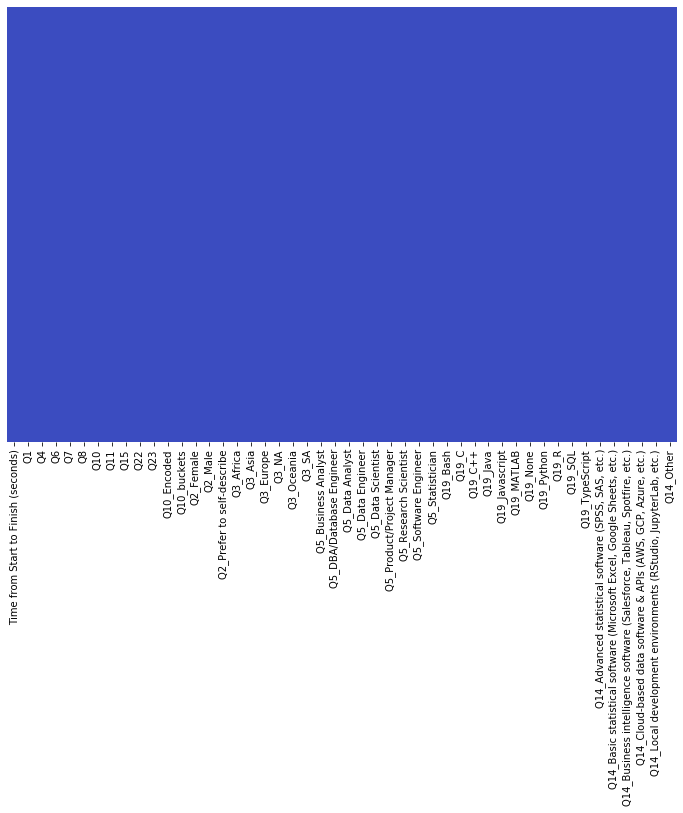

In [38]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df3.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)

Now all single response questions are cleaned. Data cleaning completes.

In [39]:
df4 = df3
for mq in qlist:
    mqlist = df1.columns[df1.columns.str.contains(mq)]
    df4 = pd.concat([df4, df1[mqlist]] ,axis=1)

Drop the original input of salary 'Q10'.

In [40]:
df4=df4.drop(['Q10'], axis=1)

### Exploratory data analysis

Heatmap is used to visualize the feature importance. The first 19 features that have high correlation values with respect to target 'Q10_Encoded' are selected and plotted. The features are considered to be most related to the target, and they are more likely to play a role in logistic regression. <br>
Absolute values are considered. +1 indicates strong positive correlation while -1 indicates strong negative correlation.

Index(['Q10_Encoded', 'Q3_NA', 'Q15', 'Q23', 'Q34_Part_1', 'Q1', 'Q9_Part_3',
       'Q3_Asia', 'Q11', 'Q9_count', 'Q8', 'Q31_Part_11', 'Q7', 'Q29_count',
       'Q6', 'Q18_Part_3', 'Q12_Part_6', 'Q25_Part_7', 'Q4', 'Q18_count'],
      dtype='object')

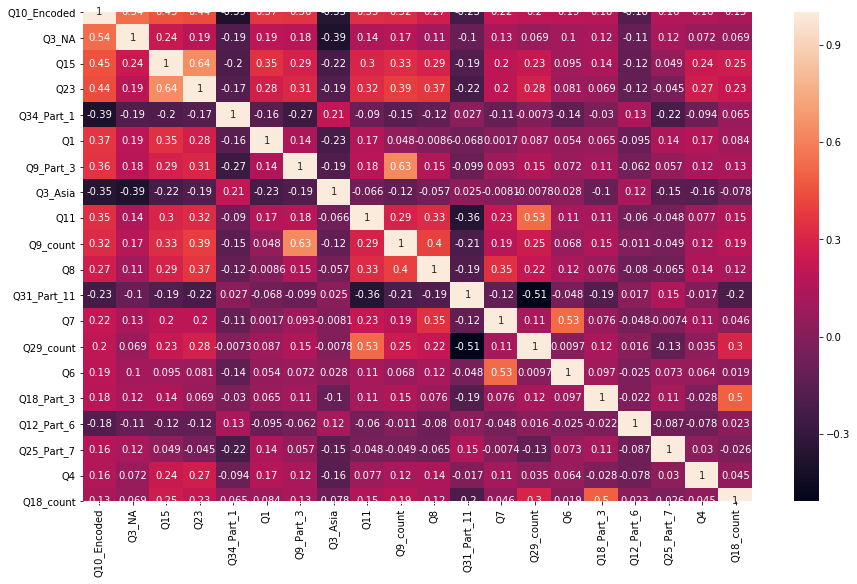

In [41]:
corr = df4.corr()
abscorr=corr.abs()
features = abscorr.nlargest(20, 'Q10_Encoded').index
df5 = df4[features]

plt.figure(figsize=(15,9))
sns.heatmap(df5.corr(),annot=True)
features

From the heatmap above, we can tell that 'Q3_NA'(if the respondent resides in North America now), 'Q15'(years of code experience), and 'Q23'(years of using machine learning method) are the three features that correlate with salary most. Then let's see how the three features affect salary.

[Text(0, 0.5, 'percent'),
 Text(0.5, 0, 'Salary'),
 Text(0.5, 1.0, 'If resides in North America')]

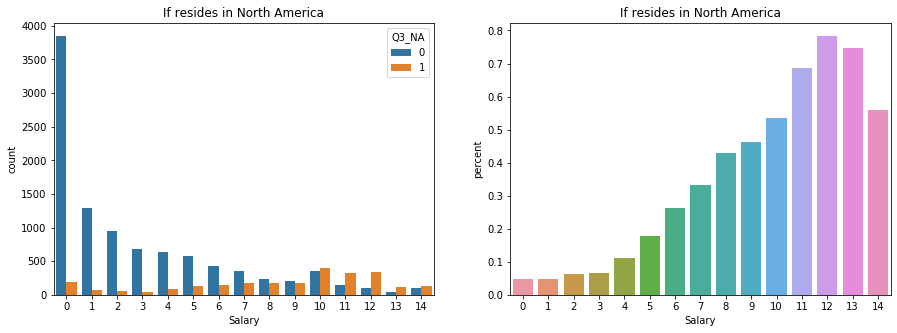

In [42]:
# 'Q3_NA': if the respondent resides in North America
fig1, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

# Plot the number of occurances for each salary bucket
q3_1 = sns.countplot(x='Q10_Encoded', hue = 'Q3_NA', data=df4, ax=ax1)
q3_1.set(xlabel='Salary', title='If resides in North America')

# Compute the mean for each salary bucket,
# Mean is the percentage of how many respondents say yes for 'Q3_NA' for each salary bucket
q3_percent = df4[['Q3_NA','Q10_Encoded']].groupby(['Q10_Encoded'], as_index=False).mean()

# Plot the mean values
q3_2 = sns.barplot(x='Q10_Encoded',y='Q3_NA', data=q3_percent, ax=ax2)
q3_2.set(xlabel='Salary', ylabel='percent', title='If resides in North America')

From the plots above, we see that the respondents with high salary have a higher probability of residing in North America than the respondents with low salary. For salary code 0 to 3, the percentages of residing in North America are all less than 0.1. For salary code 10 to 14, which are the 5 highest salary buckets, the percentages are all greater than 0.5.

Year code: {'1-2 years': 2, 'I have never written code': 0, '< 1 years': 1, '20+ years': 6, '3-5 years': 3, '5-10 years': 4, '10-20 years': 5}


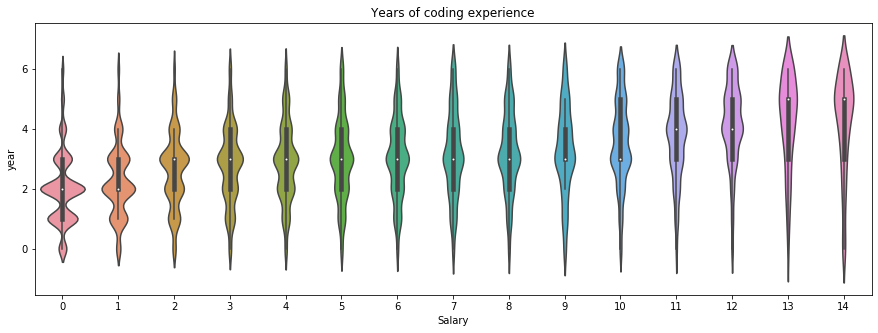

In [43]:
# 'Q15': how many years of code experience respondents have
fig2, ax1 = plt.subplots(1,1, figsize=(15,5))

# Plot years of code experience with respect to salary bucket
q15_plot = sns.violinplot(x='Q10_Encoded', y='Q15', data=df4, ax=ax1)
q15_plot.set(xlabel='Salary', ylabel='year', title='Years of coding experience')

print ('Year code:', q15_dict)

The violin plot above indicates that respondents with very high salary tend to have more than 10 years of coding experience. Most respondents with low salary have less than 5 years of coding experience since their violins have wider parts in the middle or below.

{'1-2 years': 1,
 '< 1 years': 0,
 '2-3 years': 2,
 '10-15 years': 6,
 '3-4 years': 3,
 '4-5 years': 4,
 '5-10 years': 5,
 '20+ years': 7}

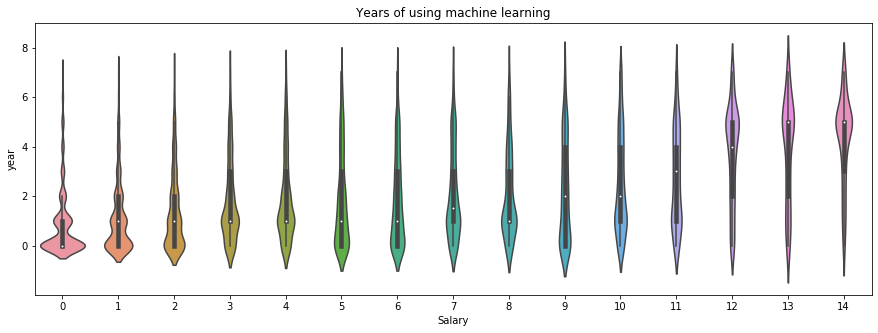

In [44]:
# 'Q23': how many years of using machine learning respondents have
fig3, ax1 = plt.subplots(1,1, figsize=(15,5))

# Plot years of using machine learning with respect to salary bucket
q23_plot = sns.violinplot(x='Q10_Encoded', y='Q23', data=df4, ax=ax1)
q23_plot.set(xlabel='Salary', ylabel='year', title='Years of using machine learning')
q23_dict

The violin plot of 'Q23' shows a similar trend with the violin plot of 'Q15'. Respondents with very high salary (12, 13, 14) are likely to have more than 5 years of using machine learning. Most respondents with low salary have less than 2 years of using machine learning. 'Q15' and 'Q23' tell the same thing that if a respondent has long-time experience of data science, such as over 5 years, the respondent has a high probability to be paid with high salary.

### Feature selection
There are 83 features (excluding 2 target columns from total 85 columns) existing in the cleaned data. Many of them may not be quite relevant to the target, and considering all existing features slows modelling. Therefore, we need to select the features with high relevance to the target and use them to build a model.Good choice of features helps a model learn fast and increases accuracy of prediction.<br>
To reduce the number of features, regularized regression with L1 regularization technique is applied. A pelnaty term of magnitude of weight coefficients is added to cost function, so that the weight coefficients are minimized as well. Then we use the features with non-zero coefficients to do logistic regression. <br>

$ h_\theta (x^{(i)}) = \sum_{j=1}(x^{(i)}_j*\theta_j) $

$J(\theta) = \frac{1}{2m}[\sum_{i=1}^m(h_\theta (x^{(i)}) - y^{(i)})^2 + \lambda\sum_{j=1}^n|\theta_j|]$

In [45]:
scaler = StandardScaler()

In [46]:
X = df4.drop(['Q10_Encoded', 'Q10_buckets'], axis=1)
y = df4['Q10_Encoded']

In [47]:
X_scaled = scaler.fit_transform(X)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Now we can apply linear regression to select features. Sklearn has a 'Lasso' function to do the l1 regularized regression.

In [48]:
def feature_select(Xtrain, Xtest, ytrain, ytest, alpha=0.1):
  lasso = Lasso(alpha, max_iter=10e4)     #Use lasso
  lasso.fit(Xtrain, ytrain)
  train_score = lasso.score(Xtrain,ytrain)
  test_score = lasso.score(Xtest,ytest)
  coeff = np.sum(lasso.coef_!=0)
    
  lr = LinearRegression()    #Linear regression without l1 regularization
  lr.fit(Xtrain, ytrain)
  lr_train_score = lr.score(Xtrain, ytrain)
  lr_test_score = lr.score(Xtest, ytest)
    
  gap = abs(train_score-lr_train_score)/lr_train_score   #print results if the two scores are close enough
    
  if gap < 0.01:
    print ('alpha=', alpha)
    print ('lasso train:', train_score)
    print ('lasso test:', test_score)
    print ('number of features selected', coeff)
    print ('LR train:', lr_train_score)
    print ('LR test:', lr_test_score)
    
  return lasso.coef_

R^2 score is used to evaluate fitting performance of regularized regression. We can compare scores of the original training set and the training set with selected features which are the features with non-zero coefficients. If they are close, then we can build a model with the selected features. We also do the same thing for test set. 

In [49]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_scaled, y, test_size=0.3)  #split original set to training set and test set
for i in [1,0.1,0.01,0.001,0.0001]:
    co=feature_select(Xtrain, Xtest, ytrain, ytest, i)
    print ('\n')





alpha= 0.01
lasso train: 0.6058794235788436
lasso test: 0.5843007731749402
number of features selected 72
LR train: 0.6065055123529177
LR test: 0.58355631219243


alpha= 0.001
lasso train: 0.6064906587789509
lasso test: 0.5837035621158083
number of features selected 82
LR train: 0.6065055123529177
LR test: 0.58355631219243


alpha= 0.0001
lasso train: 0.6065063597546754
lasso test: 0.5835756109957486
number of features selected 82
LR train: 0.6065055123529177
LR test: 0.58355631219243




Scores of regularized regression and normal linear regulation are close at alpha=0.01, which means a regression model with selected features would perform as well as a model with all features. Though lasso score is higher with smaller alpha, the number of selected features increases. <br>
Use alpha=0.01 to select features.

In [50]:
colist=feature_select(Xtrain, Xtest, ytrain, ytest, 0.01)

alpha= 0.01
lasso train: 0.6058794235788436
lasso test: 0.5843007731749402
number of features selected 72
LR train: 0.6065055123529177
LR test: 0.58355631219243


In [51]:
df5=df4
droplist=[]
for i in range(len(colist)):
    if colist[i]<0.00001:
      droplist.append(i)
      df5 = df5.drop(X.columns[i], axis=1)


### Model implementation

In [52]:
import warnings
warnings.filterwarnings("ignore")

In [53]:
X = df5.drop(['Q10_Encoded', 'Q10_buckets'], axis=1)
y = df5['Q10_Encoded']

#### Split the data and target
We split the data into a training set and a test set with a 70%-30% split. Use sklearn function train_test_split to split data.

In [54]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3) 

#### 10-fold Cross Validation
An ideal model predicts accurately for all samples, so we want to build a model with low bias and low variance.
- Use sklearn function LogisticRegression to fit a model.

- 10-fold cross validation: The training set is split into 10 equal sizes. 9 subsets are used for training, and the remaining 1 subset is used for testing. This process runs 10 times, and each time a different subset is used for testing. At the end, we obtain 10 accuracies for the training set, and we get average accuracy and standard deviation of the accuracy. High average accuracy means a good fit and a low bias of a model. Low standard deviation of accuracy indicates prediction results of subsets have similar accuracy, so the model prediction has low variance.
- accuracy = (TruePositive + TrueNegative) / (TruePositive + TrueNegative + FalsePositive + FalseNegative)



In [55]:
# Split the training set into 10 folds for cross validation 
kfold = KFold(n_splits=10)
kfold.get_n_splits(Xtrain)
model = LogisticRegression()
accuracy = np.zeros(10)
np_idx = 0

for train_idx, test_idx in kfold.split(Xtrain):
    X_train, X_test = Xtrain.values[train_idx], Xtrain.values[test_idx]
    y_train, y_test = ytrain.values[train_idx], ytrain.values[test_idx]
    
    X_train = scaler.fit_transform(X_train)    # standardize data
    X_test = scaler.transform(X_test)
    
    model.fit(X_train, y_train)     #fit data to the model
    
    ACC = 100*model.score(X_test, y_test)
    accuracy[np_idx] = ACC    
    np_idx += 1
    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC,3)))      #round accuracy to 3-digit float

print ("Average Score: {}%".format(round(np.mean(accuracy),3)))   #print average and std of accuracy
print ("Standard Deviation of Score: {}%".format(round(np.std(accuracy),3)))

Fold 1: Accuracy: 38.971%
Fold 2: Accuracy: 36.571%
Fold 3: Accuracy: 38.971%
Fold 4: Accuracy: 34.743%
Fold 5: Accuracy: 34.4%
Fold 6: Accuracy: 37.257%
Fold 7: Accuracy: 36.8%
Fold 8: Accuracy: 36.728%
Fold 9: Accuracy: 34.211%
Fold 10: Accuracy: 40.732%
Average Score: 36.938%
Standard Deviation of Score: 2.041%


Average accuracy is around 38%. Fold accuracies are similar as standard deviation of accuracy is small.

### Model Tuning

Then we select a best model based on bias-variance trade-off. 
- Bias is calculated as E( E(h(x)) - E(y) ).
- Variance is calculated as E( h(x) - E(h(x)) ).
- Use cross-entropy loss to calculate train error and test error as prediction returns probability of a sample belonging to each class.

In [56]:
# Define functions to calculate bias and variance.
def bias_calculation(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  y1 = np.mean(y_true)
  y2 = np.mean(y_pred)
  return np.power((y1-y2),2)
def var_calculation(y_pred):
  m = np.mean(y_pred)
  squared = np.power((y_pred-m),2)
  return np.mean(squared)

In [57]:
kfold = KFold(n_splits=10)
kfold.get_n_splits(Xtrain)
solver_list=['newton-cg','lbfgs','saga','sag']
C_list = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

s_bias_list = []
s_variance_list = []

s_train_error_list = []
s_test_error_list = []

for s in solver_list:
  bias_list = []
  variance_list = []
  train_error_list = []
  test_error_list = []

  for c in C_list:
    model = LogisticRegression(C=c, solver=s)
    bias=[]
    variance=[]
    train_error=[]
    test_error=[]
    for train_idx, test_idx in kfold.split(Xtrain):

      X_train, X_test = Xtrain.values[train_idx], Xtrain.values[test_idx]
      y_train, y_test = ytrain.values[train_idx], ytrain.values[test_idx]
    
      X_train = scaler.fit_transform(X_train)    # standardize data
      X_test = scaler.transform(X_test)
    
      model.fit(X_train, y_train)     #fit data to the model
    
      y_train_pred = model.predict(X_train)    #predict on the training set and test set of this fold
      y_test_pred = model.predict(X_test)
      y_train_prob = model.predict_proba(X_train)    #predict probability
      y_test_prob = model.predict_proba(X_test)

      trainerror = log_loss(y_train, y_train_prob)     #calculate error with cross-entropy loss
      testerror = log_loss(y_test, y_test_prob)
      bias_ = bias_calculation(y_test, y_test_pred)
      var_ = var_calculation(y_test_pred)
    
      train_error.append(trainerror)
      test_error.append(testerror)
      bias.append(bias_)
      variance.append(var_)
      
    bias_list.append(np.mean(bias))
    variance_list.append(np.mean(variance))
    train_error_list.append(np.mean(train_error))
    test_error_list.append(np.mean(test_error))

  s_bias_list.append(bias_list)
  s_variance_list.append(variance_list)
  s_train_error_list.append(train_error_list)
  s_test_error_list.append(test_error_list)


Plot bias-variance vs C for each solver.

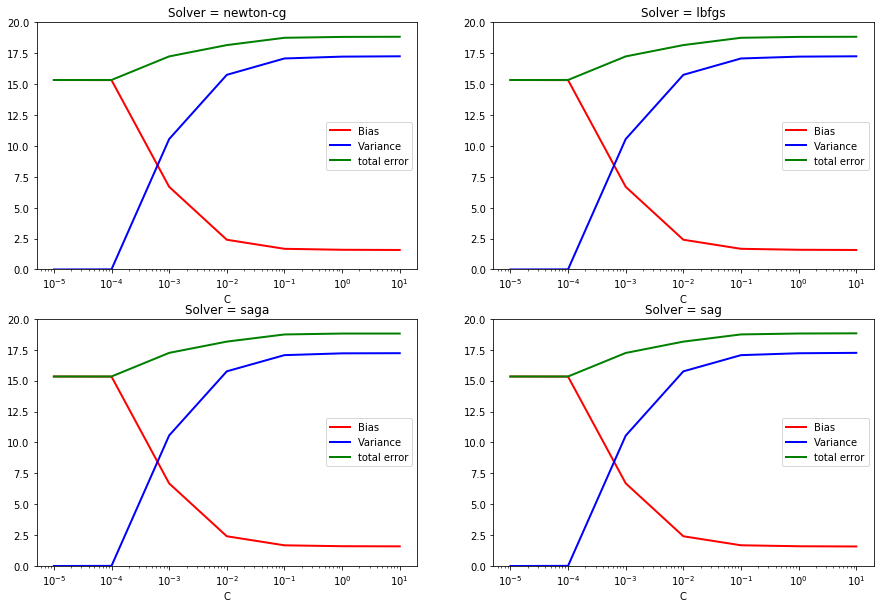

In [58]:
variance_list = np.array(s_variance_list)
bias_list = np.array(s_bias_list)
train_error_list = np.array(s_train_error_list)
test_error_list = np.array(s_test_error_list)

total_list = variance_list + bias_list
total_error_list = train_error_list + test_error_list

fig = plt.subplots(2, 2, figsize=(15, 10))

for i in range(len(solver_list)):
  plt.subplot(2,2,i+1)
  plt.plot(C_list, bias_list[i], color="red",label="Bias",linewidth = 2)
  plt.plot(C_list, variance_list[i], color="blue", label="Variance", linewidth = 2)
  plt.plot(C_list, total_list[i], color="green", label="total error", linewidth = 2)
  plt.semilogx()
  plt.ylim(0, 20)
  plt.xlabel('C')
  plt.title('Solver = {}'.format(solver_list[i]))
  plt.legend(loc='best')

  The bias-variance plots show that the effect of varying solver on value and trend of bias and variance is extremely small. The four plots look almost identical.<br>
  As C increases, bias decreases while variance goes up. To consider bias variance trade-off, C=0.001 would be the best C as the bias is low and the variance is not too high.<br>
  Then let's select a solver by comparing bias.

In [59]:
idx = np.where(np.array(C_list)==0.001)

for i in range(len(solver_list)):
  print ('Solver:', solver_list[i])
  print ('Bias at C=0.001', bias_list[i][idx])

Solver: newton-cg
Bias at C=0.001 [6.69089453]
Solver: lbfgs
Bias at C=0.001 [6.69089453]
Solver: saga
Bias at C=0.001 [6.68376846]
Solver: sag
Bias at C=0.001 [6.69206226]


All solvers have the same bias values at C=0.001. We can pick any solver for logistic regression at C=0.001.<br>
Then let's see training error and testing error.

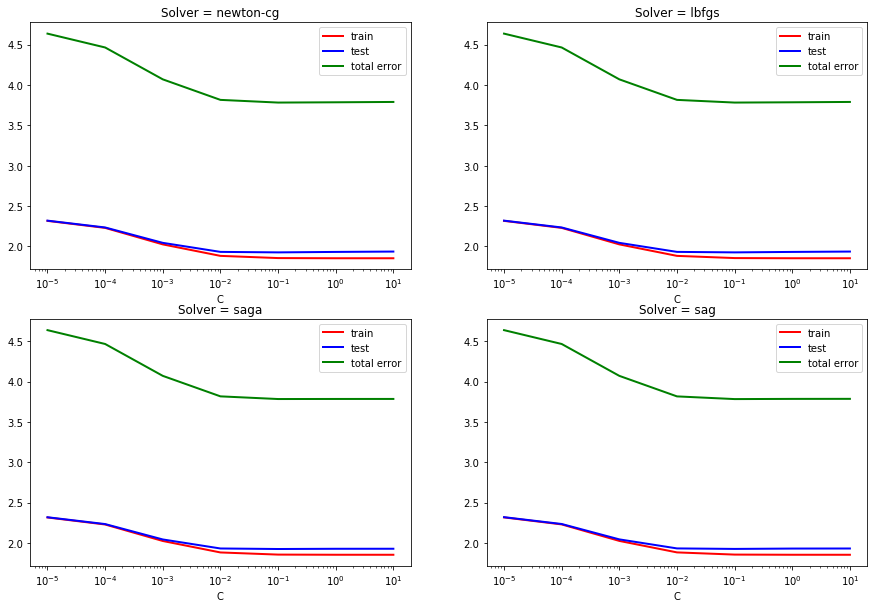

In [60]:
fig = plt.subplots(2, 2, figsize=(15, 10))

for i in range(len(solver_list)):
  plt.subplot(2,2,i+1)
  plt.plot(C_list, train_error_list[i], color="red",label="train",linewidth = 2)
  plt.plot(C_list, test_error_list[i], color="blue", label="test", linewidth = 2)
  plt.plot(C_list, total_error_list[i], color="green", label="total error", linewidth = 2)
  plt.semilogx()
  plt.xlabel('C')
  plt.title('Solver = {}'.format(solver_list[i]))
  plt.legend(loc='best')

The error plots show that the effect of varying solver on value and trend of train error and test error is extremely small. The four plots look almost identical.<br>
  As C increases, both train error and test error decrease, while their gap increases. For C>=0.1, test error reaches a plateau. The gap between train error and test error is very small for all C and the gap keeps almost unchanged for C>=0.1. The model is less likely to overfit due to the small gap. We would like to select a smaller C based on bias-variance trade-off.<br>
  Therefore, C=0.1 can be selected to build a logistic regression model. <br>
  Then let's select a solver by comparing test error.

In [61]:
idx = np.where(np.array(C_list)==0.1)

for i in range(len(solver_list)):
  print ('Solver:', solver_list[i])
  print ('Test error at C=0.1', test_error_list[i][idx])

Solver: newton-cg
Test error at C=0.1 [1.92650377]
Solver: lbfgs
Test error at C=0.1 [1.926505]
Solver: saga
Test error at C=0.1 [1.92632737]
Solver: sag
Test error at C=0.1 [1.92637509]


At C=0.1, 'saga' have the lowest train error values. <br>
Based on test error, the best model has C=0.1 and solver 'saga'.

Now let's select an optimal model based on accuracy.

In [62]:
solver_list=['newton-cg','lbfgs','saga','sag']
C_list = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

accuracy_train_list = []
recall_train_list = []
accuracy_test_list = []
recall_test_list = []

for s in solver_list:
  acc_train_list = []
  rec_train_list = []
  acc_test_list = []
  rec_test_list = []

  for c in C_list:
    model = LogisticRegression(C=c, solver=s)
    
    X_train = scaler.fit_transform(Xtrain)    # standardize data
    X_test = scaler.transform(Xtest)
    
    model.fit(X_train, ytrain)     #fit data to the model
    
    y_train_pred = model.predict(X_train)    #predict on the training set and test set of this fold
    y_test_pred = model.predict(X_test)

    acc_train = accuracy_score(ytrain, y_train_pred)
    acc_test = accuracy_score(ytest, y_test_pred)
    rec_train = recall_score(ytrain, y_train_pred, average='weighted')
    rec_test = recall_score(ytest, y_test_pred, average='weighted')
      
    acc_train_list.append(acc_train)
    acc_test_list.append(acc_test)
    rec_train_list.append(rec_train)
    rec_test_list.append(rec_test)

  accuracy_train_list.append(acc_train_list)
  accuracy_test_list.append(acc_test_list)
  recall_train_list.append(rec_train_list)
  recall_test_list.append(rec_test_list)

Let's see accuracy and recall of train set and test set for different C and solver.

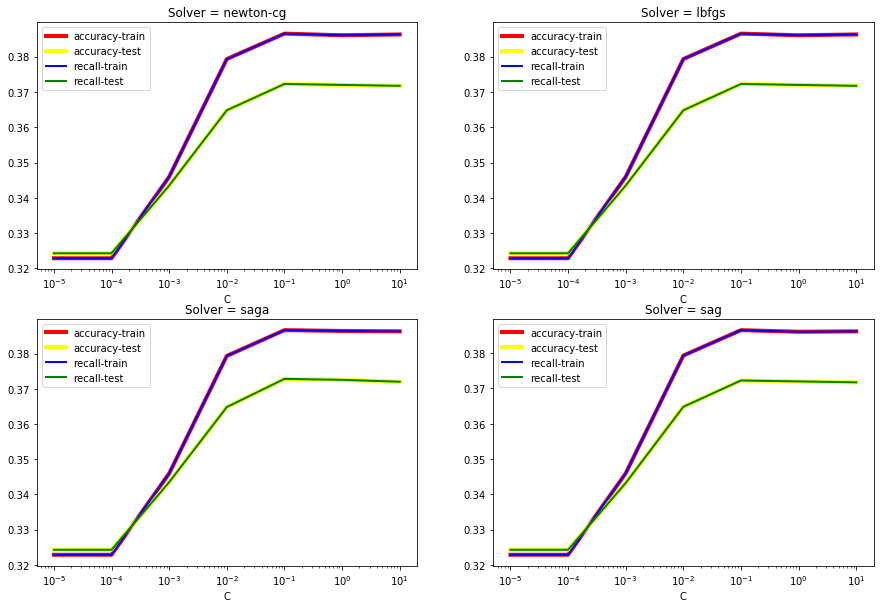

In [63]:
fig = plt.subplots(2, 2, figsize=(15, 10))

for i in range(len(solver_list)):
  plt.subplot(2,2,i+1)
  plt.plot(C_list, accuracy_train_list[i], color="red", label="accuracy-train",linewidth = 4)
  plt.plot(C_list, accuracy_test_list[i], color="yellow", label="accuracy-test",linewidth = 4)
  plt.plot(C_list, recall_train_list[i], color="blue", label="recall-train",linewidth = 2)
  plt.plot(C_list, recall_test_list[i], color="green", label="recall-test",linewidth = 2)
  plt.semilogx()
  plt.xlabel('C')
  plt.title('Solver = {}'.format(solver_list[i]))
  plt.legend(loc='best')

- From the plots above, we see that accuracy and recall scores are very close for the same dataset. Impact of solve is very small as the four plots look almost identical. Both accuracy and recall increases with C.
- Test scores are higher than train scores for C<=0.001 but lower than train scores for C>=0.01.
- Accuracy reaches the top of graph at C=0.1 and stays around 0.395 for C>0.1.
- Select solver based on test scores since test scores are lower than train scores at C=0.1 and we want scores to be as high as possible. 

In [64]:
idx = np.where(np.array(C_list)==0.1)

for i in range(len(solver_list)):
  print ('Solver:', solver_list[i])
  print ('Test Accuracy at C=0.1', np.array(accuracy_test_list)[i][idx])
  print ('Test Recall at C=0.1', np.array(recall_test_list)[i][idx])
  print ('Train Accuracy at C=0.1', np.array(accuracy_train_list)[i][idx])
  print ('Train Recall at C=0.1', np.array(recall_train_list)[i][idx])

Solver: newton-cg
Test Accuracy at C=0.1 [0.37226667]
Test Recall at C=0.1 [0.37226667]
Train Accuracy at C=0.1 [0.38653253]
Train Recall at C=0.1 [0.38653253]
Solver: lbfgs
Test Accuracy at C=0.1 [0.37226667]
Test Recall at C=0.1 [0.37226667]
Train Accuracy at C=0.1 [0.38653253]
Train Recall at C=0.1 [0.38653253]
Solver: saga
Test Accuracy at C=0.1 [0.3728]
Test Recall at C=0.1 [0.3728]
Train Accuracy at C=0.1 [0.38664685]
Train Recall at C=0.1 [0.38664685]
Solver: sag
Test Accuracy at C=0.1 [0.37226667]
Test Recall at C=0.1 [0.37226667]
Train Accuracy at C=0.1 [0.38653253]
Train Recall at C=0.1 [0.38653253]


At C=0.1, 'saga' has the highest accuracy and recall scores.<br>
In terms of bias-variance trade-off, train error and test error, and performance measure, an optimal model has C=0.1 and solver 'saga'.

### Testing and Discussion
Use C = 1 and solver = 'saga' to create a logistic regression model. Use the model to predict test data.

In [66]:
model = LogisticRegression(C=0.1, solver='saga')
    
X_train = scaler.fit_transform(Xtrain)    # standardize data
X_test = scaler.transform(Xtest)
    
model.fit(X_train, ytrain)     #fit data to the model
    
y_train_pred = model.predict(X_train)    #predict on the training set and test set of this fold
y_test_pred = model.predict(X_test)
y_test_probability = model.predict_proba(X_test)
acc_train = accuracy_score(ytrain, y_train_pred)
acc_test = accuracy_score(ytest, y_test_pred)

print ('Train accuracy:', acc_train)
print ('Test accuracy:', acc_test)

Train accuracy: 0.386646850348691
Test accuracy: 0.3728


Train accuracy and test accuracy are close. Train accuracy is slightly higher than test accuracy, but their gap can be overlooked.
This model is underfitting as the accuracy scores are lower than 0.5, which means the model mispredicts more than half of the train set and the test set.

The sample actually belongs to class 2
The sample is predicted to belong to class 1


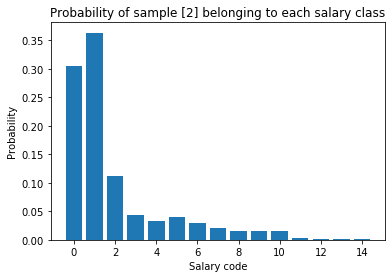

In [68]:
# Print prediction result of sample[1] in test set
s = range(15)  #salary code
plt.bar(s,y_test_probability[1])
plt.xlabel('Salary code')
plt.ylabel('Probability')
plt.title('Probability of sample [2] belonging to each salary class')
print ('The sample actually belongs to class', ytest.iloc[1])
print ('The sample is predicted to belong to class', y_test_pred[1])

[Text(0.5, 0, 'Salary'), Text(0.5, 1.0, 'Test set')]

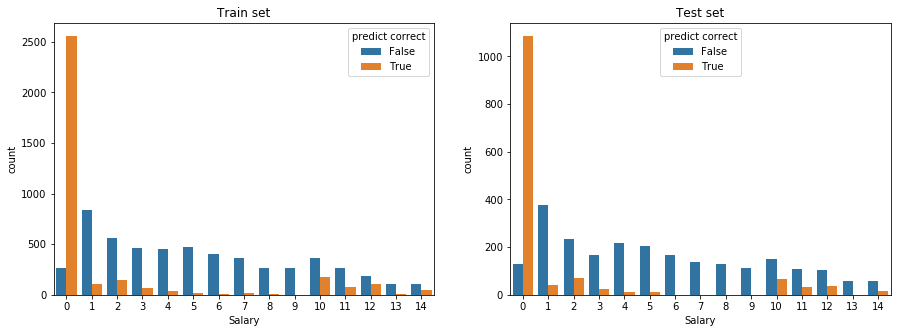

In [69]:
#fig, ax = plt.subplots(1, 2, figsize=(15, 8))
result = {'true': ytrain,
          'predict': y_train_pred}
result_test =  {'true': ytest,
          'predict': y_test_pred}
train_result = pd.DataFrame(result)
test_result = pd.DataFrame(result_test)
train_result['predict correct']=train_result['true']==train_result['predict']
test_result['predict correct']=test_result['true']==test_result['predict']
train_percent = train_result[['predict correct','true']].groupby(['true'], as_index=False).mean()
test_percent = test_result[['predict correct','true']].groupby(['true'], as_index=False).mean()

fig1, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
trainplot = sns.countplot(x='true', hue = 'predict correct', data=train_result, ax=ax1)
trainplot.set(xlabel='Salary', title='Train set')

testplot = sns.countplot(x='true', hue = 'predict correct', data=test_result, ax=ax2)
testplot.set(xlabel='Salary', title='Test set')


[Text(0.5, 0, 'Salary'), Text(0.5, 1.0, 'Test set')]

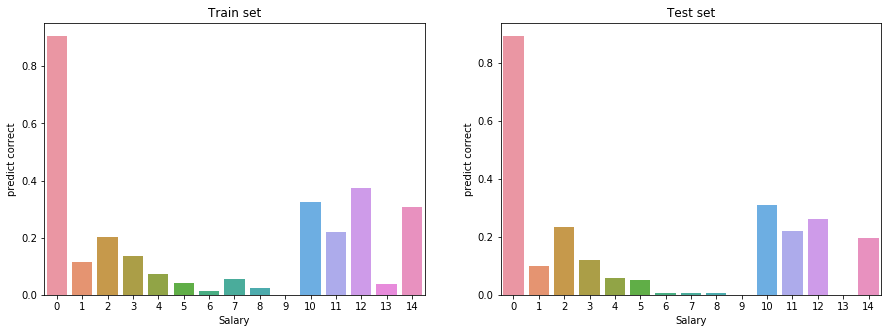

In [70]:
#Calculate the accuracy rate of train set and test set
#which is #pred_correct/#total_samples
train_percent = train_result[['predict correct','true']].groupby(['true'], as_index=False).mean()
test_percent = test_result[['predict correct','true']].groupby(['true'], as_index=False).mean()

fig1, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
trainplot = sns.barplot(x='true', y = 'predict correct', data=train_percent, ax=ax1)
trainplot.set(xlabel='Salary', title='Train set')

testplot = sns.barplot(x='true', y = 'predict correct', data=test_percent, ax=ax2)
testplot.set(xlabel='Salary', title='Test set')

- As shown in the graphs above, low salary buckets (0, 1, 2, 3, 4, especially 0) and high salary buckets (10, 11, 12, 13, 14) generally have higher accurate prediction rate than middle salary buckets(5, 6, 7, 8, 9). Samples with middle salary classes may be very similar in terms of features, so model is hard to identify them.
- Accuracy has something to do with the number of samples. Salary 0 has the largest amount of samples, and it has the highest accuracy rate. Model predict more accurately if there are a large number of samples for training.
- If we increase size of salary buckets, prediction would be more accurate. For example, salary 0 becomes $0-20000, then the number of salary buckets decreases and we have fewer labels a model need for classification.

Accuracy can be increased by cleaning data, selecting features, normalizing data, modifying hyperparameters, and changing model. 
- Cleaning out irrelevant data and arrange data in a reasonable way help model identify contribution of features to target better. 
- Selecting most related features help reduce running time and unnecessary impact of other features on fitting.
- Normalizing data reduces impact on weights due to different scale of feature values.
- Modifying hyperparameters give us the optimal model based on specific performance measures. <br>
- We have implemented most of the methods, but we haven't tried using other models, such as decision tree. We can also try other types of classification model and compare model performance.